In [1]:
import numpy as np
import gym
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

In [2]:
# Create gym environment
env = gym.make('Pendulum-v0')
env.reset()
#action space is a Box(1,) with values between [-2,2], joint effort
print(env.action_space.low)
#observation space is 3d angle of pendulum cos, sin, velocity max:1,1,8; min:-1,-1,8
print(env.observation_space.low)

[-2.]
[-1. -1. -8.]


In [24]:
#reward formular: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2) (-16.27 is worst, 0 best)
print(env.reset())
a = env.action_space.sample()
print(a)
state, reward, done, info = env.step(a)
print(state, reward, done, info)

[ 0.8546468  -0.51920982  0.14026657]
[-0.6469883]
[ 0.84553198 -0.53392477 -0.34618903] -0.3004214009065363 False {}


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


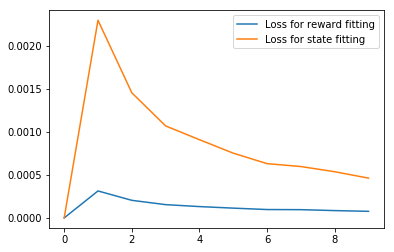

In [77]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


rtx = []
rty = []
stx = []
sty = []
plotr = []
plots = []
for i in range(epochs):
    observation = env.reset()

    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    rtx.append(np.append(observation,action))
    rty.append(reward)
    stx.append(np.append(observation,action))
    sty.append(state)
    #observation = state
    if i%500==0:
        regressorReward = RandomForestRegressor(n_estimators=10, min_samples_split=2)
        regressorReward.fit(rtx, rty)
        fitrtx = regressorReward.predict(rtx)
        mse = mean_squared_error(rty, fitrtx)
        plotr.append(mse)

        regressorState = RandomForestRegressor(n_estimators=10, min_samples_split=2)
        regressorState.fit(stx, sty)
        fitstx = regressorState.predict(stx)
        mse = mean_squared_error(sty, fitstx)

        plots.append(mse)

plt.figure(0)
plt.plot(plotr, label="Loss for reward fitting")

plt.plot(plots, label="Loss for state fitting")
plt.legend()
print(regressorReward)

In [106]:
# Neural network model for transition dynamics
# Learns regression from state and action to resulting state and reward
'''class ControlNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ControlNet, self).__init__()
        self.input_linear = torch.nn.Linear(input_dim, hidden_dim1)
        self.middle_linear = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.output_linear = torch.nn.Linear(hidden_dim2, output_dim)
    def forward(self, x):
        x = F.relu(self.input_linear(x))
        x = F.relu(self.middle_linear(x))
        x = F.relu(self.output_linear(x))
        return x
'''
# Neural network model for transition dynamics
# Learns regression from state and action to resulting state and reward
class ControlNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(ControlNet, self).__init__()
        self.input_linear = torch.nn.Linear(input_dim, hidden_dim1)
        self.input_linear2 = torch.nn.Linear(hidden_dim1, output_dim)

    def forward(self, x):
        x =self.input_linear(x)
        x = self.input_linear2(x)
        return x

In [109]:
# Batch size, input dimension, hidden dimension, output dimension
# Use  next for next_state + reward as output
# n, d_in, d_hid1, d_hid2, d_out = 1, 4, 16, 64, 4 
# Use next for next_state as only output
n, d_in, d_hid1, d_hid2, d_out = 1, 4, 16, 64, 3
# Instance of nn model
#model = ControlNet(d_in, d_hid1, d_hid2, d_out).double()
model = ControlNet(4,6,3).double()
# Criterion for optimisation: Mean Squared Loss
criterion = torch.nn.MSELoss(reduction='sum') # reduction sum???
# Learning rate for nn
l_rate = 0.01
# Optimizer: Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=l_rate)
# Learning episodes
epochs = 10000

In [15]:
# Policy: Random action
def policy(s):
    a = env.action_space.sample()
    return a

Training the network...


... done


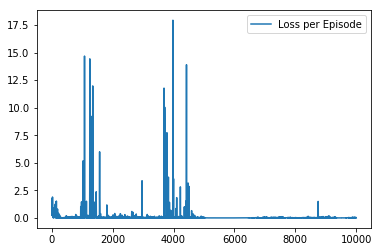

In [110]:
# Training the model

plot = []
state = env.reset()
print("Training the network...")

for epoch in range(epochs):
    # Render gym environment
    # env.render()
    # Select action according to policy
   
    action = policy(state)
    # Observations
    old_state = state
    state, reward, done, info = env.step(action)
    # Define tensors holding data
    x = Variable(torch.from_numpy(np.array([old_state[0], old_state[1], old_state[2], action])), requires_grad=True)
    #y = model.forward(x)
    y = model(x)
    # Use  next for next_state + reward as output
    # true_y = Variable(torch.from_numpy(np.array([state[0], state[1], state[2], reward])), requires_grad=True)
    # Use next for next_state only as output
    true_y = Variable(torch.from_numpy(np.array([state[0], state[1], state[2]])), requires_grad=True)
    # Prints
    #print("net input tensor: {} with shape {}".format(net_input,net_input.dim))
    
    
    # Compute loss
    #loss = Variable(criterion(true_y, y), requires_grad=True)
    loss =criterion(y, true_y)
    plot.append(loss)
    # Clear gradients, backpropagation and weight update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("... done")

env.close()
# Plot loss
plt.figure()
plt.plot(plot, label="Loss per Episode")
plt.legend()
plt.show()